<a href="https://colab.research.google.com/github/eternallysunny/1st_semantic_segmentation_project/blob/main/1st_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.gridspec as gridspec

## COCO data handling
https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047

https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-2-of-2-c0d1f593096a

https://github.com/virafpatrawala/COCO-Semantic-Segmentation/blob/master/COCOdataset_SemanticSegmentation_Demo.ipynb

In [ ]:
train_df = "E:/Viki_DS_Project/cocodataset_2014/train2014"
val_df = "E:/Viki_DS_Project/cocodataset_2014/val2014"
train_annot_file = "E:/Viki_DS_Project/cocodataset_2014/annotations/instances_train2014.json"
val_annot_file = "E:/Viki_DS_Project/cocodataset_2014/annotations/instances_val2014.json"

In [ ]:
coco = COCO(train_annot_file)
cats = coco.loadCats(coco.getCatIds())
#print(cats)

# Specify a list of category names of interest
cat_catId = coco.getCatIds(catNms=['cat'])

# Get the corresponding image ids and images using loadImgs
cat_imgIds = coco.getImgIds(catIds=cat_catId)[0:500]
cat_images = coco.loadImgs(cat_imgIds)

loading annotations into memory...
Done (t=11.79s)
creating index...
index created!


In [ ]:
val_coco = COCO(val_annot_file)
val_cats = val_coco.loadCats(val_coco.getCatIds())
#print(cats)

# Specify a list of category names of interest
val_cat_catId = val_coco.getCatIds(catNms=['cat'])

# Get the corresponding image ids and images using loadImgs
val_cat_imgIds = val_coco.getImgIds(catIds=val_cat_catId)[0:100]
val_cat_images = val_coco.loadImgs(val_cat_imgIds)

loading annotations into memory...
Done (t=5.70s)
creating index...
index created!


### Check on example image and create masking

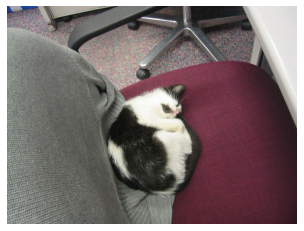

In [ ]:
# load and display a random image
img = coco.loadImgs(cat_imgIds[np.random.randint(0,len(cat_imgIds))])[0]
I = io.imread(train_df + '/' + img['file_name'])/255.0
plt.axis('off')
plt.imshow(I)
plt.show()

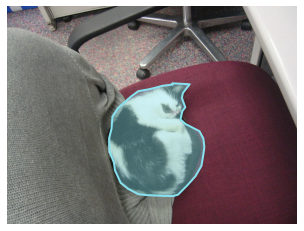

In [ ]:
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=cat_catId, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [ ]:
dataset_size = len(cat_images)
print("Number of images containing the filter classes:", dataset_size)

Number of images containing the filter classes: 500


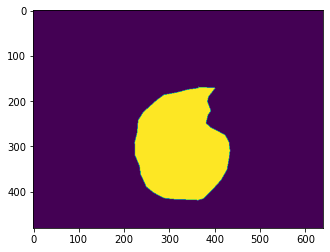

In [ ]:
# Generate binary mask
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco.annToMask(anns[i]), mask)
plt.imshow(mask)

### Get and mask images

In [ ]:
def getImages(imageObj, imageFolder, input_image_size):     
    # Read and normalize data
    train_image = io.imread(imageFolder + '/' + imageObj['file_name'])/255.0
    # Resize images
    train_image = cv2.resize(train_image, input_image_size)
    if (len(train_image.shape)==3 and train_image.shape[2]==3):  # If it is an RGB 3 channel image
        return train_image
    else: # If it is a black and white image - to increase dimensions to 3
        stacked_image = np.stack((train_image,)*3, axis=-1)
        return stacked_image

In [ ]:
def getBinaryMask(imageObj, coco_v, catIds, input_image_size):
    annot_ds = coco_v.getAnnIds(imageObj['id'], catIds = catIds, iscrowd = None)
    annots = coco_v.loadAnns(annot_ds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(annots)):
        new_mask = cv2.resize(coco_v.annToMask(annots[a]), input_image_size)
        # Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0
        
        train_mask = np.maximum(new_mask, train_mask)
    # Add extra dimensions for parity with train_image size (h * w * 3)
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

In [ ]:
def dataGeneratorCoco(images, coco_v, folder, catIds, input_image_size):
    imageFolder = folder
    dataset_size = len(images)
    catIds = catIds
    
    img = np.zeros((dataset_size, input_image_size[0], input_image_size[1], 3)).astype('float')
    mask = np.zeros((dataset_size, input_image_size[0], input_image_size[1], 1)).astype('float')
    
    for i in range(0, dataset_size):
        imageObj = images[i]
        
        train_img = getImages(imageObj, imageFolder, input_image_size)
        
        train_mask = getBinaryMask(imageObj, coco_v, catIds, input_image_size)

        img[i] = train_img
        mask[i] = train_mask
        
    return img, mask    

In [ ]:
images, masks = dataGeneratorCoco(cat_images, 
                                  coco, 
                                  train_df, 
                                  cat_catId, 
                                  input_image_size = (256, 256))

In [ ]:
val_images, val_masks = dataGeneratorCoco(images = val_cat_images, 
                                          coco_v = val_coco, 
                                          folder = val_df, 
                                          catIds = val_cat_catId, 
                                          input_image_size = (256, 256))

In [ ]:
def visualizeData(images, masks):
    fig = plt.figure(figsize = (20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace = 0.1, hspace = 0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = outerGrid[i], 
                                                     wspace = 0.05, hspace = 0.05)
        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if (i==1):
                ax.imshow(images[j])
            else:
                ax.imshow(masks[j][:, :, 0])
                
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

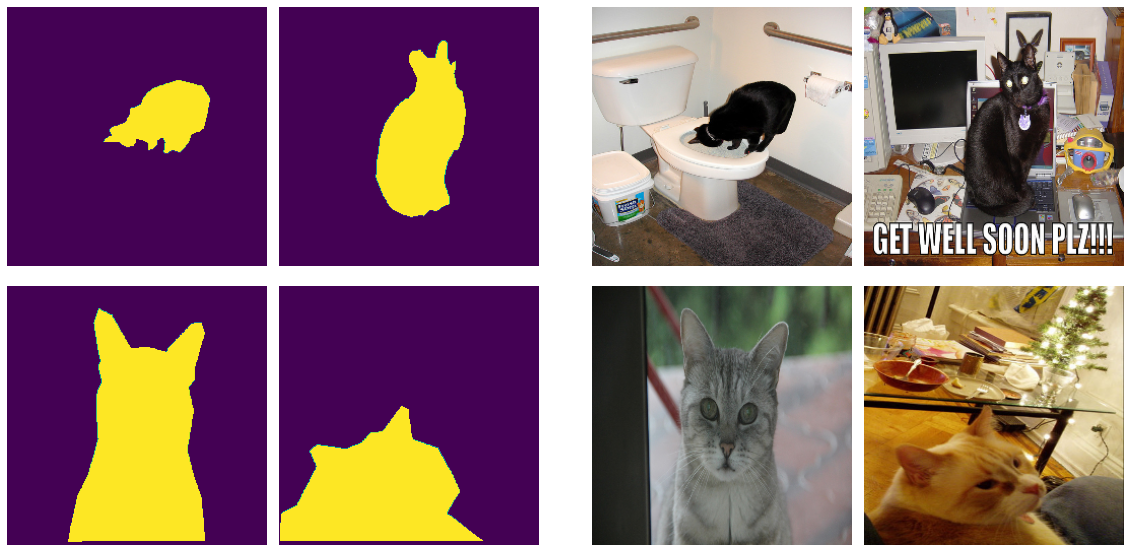

In [ ]:
visualizeData(images, masks)

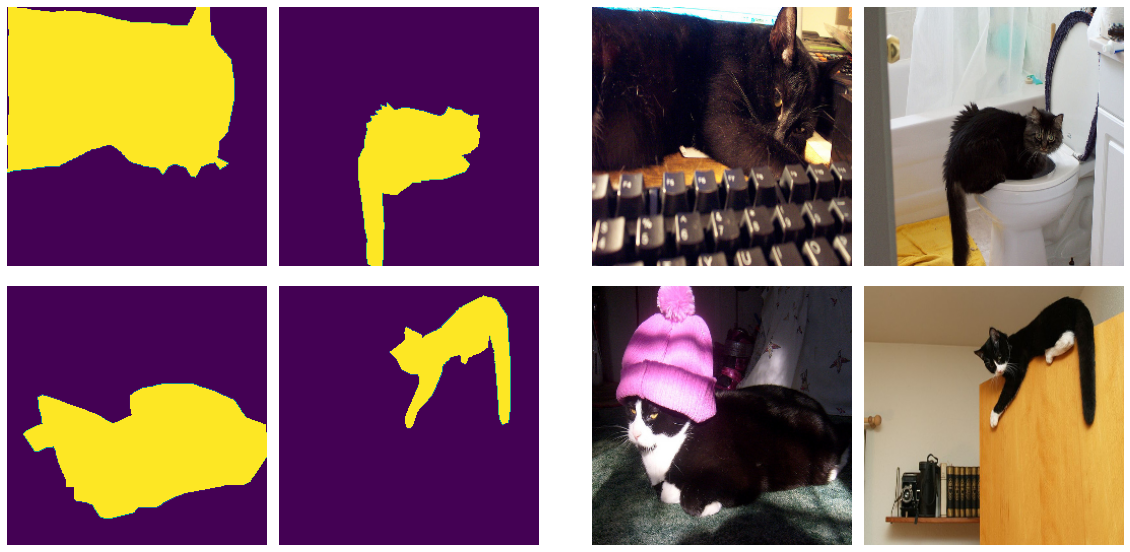

In [ ]:
visualizeData(val_images, val_masks)

## U-Net Structure
https://youtu.be/dIRbGz2Rn3w

https://youtu.be/oBIkr7CAE6g

https://github.com/bnsreenu/python_for_image_processing_APEER

https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial118_binary_semantic_segmentation_using_unet.ipynb

https://github.com/bnsreenu/python_for_image_processing_APEER/blob/master/tutorial117_building_unet_using_encoder_decoder_blocks.ipynb

In [ ]:
def UNetModel(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    x = inputs
    
    # Encoder part - contraction
    c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
    d1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d1)
    p1 = MaxPooling2D(pool_size = (2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(p1)
    d2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d2)
    p2 = MaxPooling2D(pool_size = (2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(p2)
    d3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d3)
    p3 = MaxPooling2D(pool_size = (2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(p3)
    d4 = Dropout(0.2)(c4)    
    c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d4)
    p4 = MaxPooling2D(pool_size = (2, 2))(c4)
    
    ## Bottleneck part - bottom
    c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(p4)
    d5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(d5)
    
    # Decoder part - expansion
    u6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c5))
    u6 = concatenate([u6, c4], axis = 3)
    c6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(u6)
    d6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d6)

    u7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c6))
    u7 = concatenate([u7, c3], axis = 3)
    c7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(u7)
    d7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d7)

    u8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c7))
    u8 = concatenate([u8, c2], axis = 3)
    c8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(u8)
    d8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d8)

    u9 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c8))
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(u9)
    d9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d9)

    outputs = Conv2D(N_CLASSES, (1, 1), activation = 'sigmoid')(c9)
    
    model = Model(inputs, outputs, name = 'U-Net')
    
    return model

In [ ]:
IMG_HEIGHT = images.shape[1]
IMG_WIDTH = images.shape[2]
IMG_CHANNELS =  images.shape[3]
N_CLASSES = 1
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
EPOCHS = 25

In [ ]:
model = UNetModel(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES)
model.compile(optimizer = Adam (learning_rate = LEARNING_RATE), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_297 (Conv2D)            (None, 256, 256, 16  448         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_118 (Dropout)          (None, 256, 256, 16  0           ['conv2d_297[0][0]']             
                                )                                                             

In [ ]:
train = model.fit(images, masks, 
                  batch_size = BATCH_SIZE,
                  verbose = 1, 
                  epochs = EPOCHS, 
                  validation_data = (val_images, val_masks),
                  shuffle = False)

Epoch 1/25
32/32 [==============================] - 114s 4s/step - loss: 0.7473 - accuracy: 0.8073 - val_loss: 0.4881 - val_accuracy: 0.8112
Epoch 2/25
32/32 [==============================] - 113s 4s/step - loss: 0.4729 - accuracy: 0.8146 - val_loss: 0.4736 - val_accuracy: 0.8112
Epoch 3/25
32/32 [==============================] - 114s 4s/step - loss: 0.4643 - accuracy: 0.8146 - val_loss: 0.4676 - val_accuracy: 0.8112
Epoch 4/25
32/32 [==============================] - 114s 4s/step - loss: 0.4640 - accuracy: 0.8146 - val_loss: 0.4408 - val_accuracy: 0.8112
Epoch 5/25
32/32 [==============================] - 113s 4s/step - loss: 0.4481 - accuracy: 0.8146 - val_loss: 0.4244 - val_accuracy: 0.8112
Epoch 6/25
32/32 [==============================] - 113s 4s/step - loss: 0.4319 - accuracy: 0.8146 - val_loss: 0.4380 - val_accuracy: 0.8112
Epoch 7/25
32/32 [==============================] - 113s 4s/step - loss: 0.4285 - accuracy: 0.8146 - val_loss: 0.4378 - val_accuracy: 0.8112
Epoch 8/25
32

In [ ]:
def UNetModel_v2(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    x = inputs
    
    # Encoder part - contraction
    c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
    d1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d1)
    p1 = MaxPooling2D(pool_size = (2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(p1)
    d2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d2)
    p2 = MaxPooling2D(pool_size = (2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(p2)
    d3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d3)
    p3 = MaxPooling2D(pool_size = (2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(p3)
    d4 = Dropout(0.2)(c4)    
    c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d4)
    p4 = MaxPooling2D(pool_size = (2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(p4)
    d5 = Dropout(0.3)(c5)    
    c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(d5)
    p5 = MaxPooling2D(pool_size = (2, 2))(c5)
    
    c6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(p5)
    d6 = Dropout(0.3)(c6)    
    c6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(d6)
    p6 = MaxPooling2D(pool_size = (2, 2))(c6)
    
    ## Bottleneck part - bottom
    c7 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(p6)
    d7 = Dropout(0.4)(c7)
    c7 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(d7)
    
    # Decoder part - expansion
    u8 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c7))
    u8 = concatenate([u8, c6], axis = 3)
    c8 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(u8)
    d8 = Dropout(0.3)(c8)
    c8 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(d8)

    u9 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c8))
    u9 = concatenate([u9, c5], axis = 3)
    c9 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(u9)
    d9 = Dropout(0.3)(c9)
    c9 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(d9)

    u10 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c9))
    u10 = concatenate([u10, c4], axis = 3)
    c10 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(u10)
    d10 = Dropout(0.2)(c10)
    c10 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d10)

    u11 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c10))
    u11 = concatenate([u11, c3], axis = 3)
    c11 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(u11)
    d11 = Dropout(0.2)(c11)
    c11 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d11)
    
    u12 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c11))
    u12 = concatenate([u12, c2], axis = 3)
    c12 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(u12)
    d12 = Dropout(0.1)(c12)
    c12 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d12)
    
    u13 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c12))
    u13 = concatenate([u13, c1], axis = 3)
    c13 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(u13)
    d13 = Dropout(0.1)(c13)
    c13 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d13)

    outputs = Conv2D(N_CLASSES, (1, 1), activation = 'sigmoid')(c13)
    
    model = Model(inputs, outputs, name = 'U-Net_v2')
    
    return model

In [ ]:
model_v2 = UNetModel_v2(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES)
model_v2.compile(optimizer = Adam (learning_rate = LEARNING_RATE), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model_v2.summary()

Model: "U-Net_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_353 (Conv2D)            (None, 256, 256, 16  448         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_140 (Dropout)          (None, 256, 256, 16  0           ['conv2d_353[0][0]']             
                                )                                                          

In [ ]:
train_v2 = model_v2.fit(images, masks, 
                          batch_size = BATCH_SIZE,
                          verbose = 1, 
                          epochs = EPOCHS, 
                          validation_data = (val_images, val_masks),
                          shuffle = False)

Epoch 1/25
32/32 [==============================] - 148s 5s/step - loss: 0.5512 - accuracy: 0.7783 - val_loss: 0.4794 - val_accuracy: 0.8112
Epoch 2/25
32/32 [==============================] - 146s 5s/step - loss: 0.4753 - accuracy: 0.8146 - val_loss: 0.4718 - val_accuracy: 0.8112
Epoch 3/25
32/32 [==============================] - 145s 5s/step - loss: 0.4581 - accuracy: 0.8146 - val_loss: 0.4379 - val_accuracy: 0.8112
Epoch 4/25
32/32 [==============================] - 145s 5s/step - loss: 0.4279 - accuracy: 0.8146 - val_loss: 0.4134 - val_accuracy: 0.8112
Epoch 5/25
32/32 [==============================] - 145s 5s/step - loss: 0.4126 - accuracy: 0.8148 - val_loss: 0.4006 - val_accuracy: 0.8234
Epoch 6/25
32/32 [==============================] - 146s 5s/step - loss: 0.4106 - accuracy: 0.8120 - val_loss: 0.3993 - val_accuracy: 0.8112
Epoch 7/25
32/32 [==============================] - 146s 5s/step - loss: 0.4045 - accuracy: 0.8146 - val_loss: 0.4025 - val_accuracy: 0.8227
Epoch 8/25
32

In [ ]:
def UNetModel_v3(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    x = inputs
    
    # Encoder part - contraction
    c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
    d1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d1)
    d1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d1)
    p1 = MaxPooling2D(pool_size = (2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(p1)
    d2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d2)
    d2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d2)
    p2 = MaxPooling2D(pool_size = (2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(p2)
    d3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d3)
    d3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d3)
    p3 = MaxPooling2D(pool_size = (2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(p3)
    d4 = Dropout(0.2)(c4)    
    c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d4)
    p4 = MaxPooling2D(pool_size = (2, 2))(c4)
    
    ## Bottleneck part - bottom
    c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(p4)
    d5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(d5)
    
    # Decoder part - expansion
    u6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c5))
    u6 = concatenate([u6, c4], axis = 3)
    c6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(u6)
    d6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d6)

    u7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c6))
    u7 = concatenate([u7, c3], axis = 3)
    c7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(u7)
    d7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d7)
    d7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d7)

    u8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c7))
    u8 = concatenate([u8, c2], axis = 3)
    c8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(u8)
    d8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d8)
    d8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d8)

    u9 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c8))
    u9 = concatenate([u9, c1], axis = 3)
    c9 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(u9)
    d9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d9)
    d9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d9)

    outputs = Conv2D(N_CLASSES, (1, 1), activation = 'sigmoid')(c9)
    
    model = Model(inputs, outputs, name = 'U-Net_3')
    
    return model

In [ ]:
model_v3 = UNetModel_v3(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES)
model_v3.compile(optimizer = Adam (learning_rate = LEARNING_RATE), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model_v3.summary()

Model: "U-Net_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_415 (Conv2D)            (None, 256, 256, 16  448         ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_168 (Dropout)          (None, 256, 256, 16  0           ['conv2d_415[0][0]']             
                                )                                                           

In [ ]:
train_v3 = model_v3.fit(images, masks, 
                          batch_size = BATCH_SIZE,
                          verbose = 1, 
                          epochs = EPOCHS, 
                          validation_data = (val_images, val_masks),
                          shuffle = False)

Epoch 1/25
32/32 [==============================] - 148s 5s/step - loss: 0.7393 - accuracy: 0.7856 - val_loss: 0.5568 - val_accuracy: 0.8112
Epoch 2/25
32/32 [==============================] - 147s 5s/step - loss: 0.4929 - accuracy: 0.8145 - val_loss: 0.4963 - val_accuracy: 0.8112
Epoch 3/25
32/32 [==============================] - 147s 5s/step - loss: 0.4684 - accuracy: 0.8146 - val_loss: 0.4685 - val_accuracy: 0.8112
Epoch 4/25
32/32 [==============================] - 147s 5s/step - loss: 0.4622 - accuracy: 0.8146 - val_loss: 0.4559 - val_accuracy: 0.8112
Epoch 5/25
32/32 [==============================] - 147s 5s/step - loss: 0.4503 - accuracy: 0.8146 - val_loss: 0.4517 - val_accuracy: 0.8112
Epoch 6/25
32/32 [==============================] - 147s 5s/step - loss: 0.4438 - accuracy: 0.8146 - val_loss: 0.4512 - val_accuracy: 0.8112
Epoch 7/25
32/32 [==============================] - 147s 5s/step - loss: 0.4346 - accuracy: 0.8146 - val_loss: 0.4413 - val_accuracy: 0.8112
Epoch 8/25
32

In [ ]:
def UNetModel_v4(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    x = inputs
    
    # Encoder part - contraction
    c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
    d1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d1)
    d1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d1)
    p1 = MaxPooling2D(pool_size = (2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(p1)
    d2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d2)
    d2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d2)
    p2 = MaxPooling2D(pool_size = (2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(p2)
    d3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d3)
    d3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d3)
    p3 = MaxPooling2D(pool_size = (2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(p3)
    d4 = Dropout(0.2)(c4)    
    c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d4)
    d4 = Dropout(0.2)(c4)    
    c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d4)
    p4 = MaxPooling2D(pool_size = (2, 2))(c4)
    
    c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(p4)
    d5 = Dropout(0.3)(c5)    
    c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(d5)
    d5 = Dropout(0.3)(c5)    
    c5 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(d5)
    p5 = MaxPooling2D(pool_size = (2, 2))(c5)
    
    c6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(p5)
    d6 = Dropout(0.3)(c6)    
    c6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(d6)
    d6 = Dropout(0.3)(c6)    
    c6 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(d6)
    p6 = MaxPooling2D(pool_size = (2, 2))(c6)
    
    ## Bottleneck part - bottom
    c7 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(p6)
    d7 = Dropout(0.4)(c7)
    c7 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(d7)
    d7 = Dropout(0.4)(c7)
    c7 = Conv2D(1024, (3, 3), activation = 'relu', padding = 'same')(d7)
    
    # Decoder part - expansion
    u8 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c7))
    u8 = concatenate([u8, c6], axis = 3)
    c8 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(u8)
    d8 = Dropout(0.3)(c8)
    c8 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(d8)
    d8 = Dropout(0.3)(c8)
    c8 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(d8)

    u9 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c8))
    u9 = concatenate([u9, c5], axis = 3)
    c9 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(u9)
    d9 = Dropout(0.3)(c9)
    c9 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(d9)
    d9 = Dropout(0.3)(c9)
    c9 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(d9)

    u10 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c9))
    u10 = concatenate([u10, c4], axis = 3)
    c10 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(u10)
    d10 = Dropout(0.2)(c10)
    c10 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d10)
    d10 = Dropout(0.2)(c10)
    c10 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(d10)

    u11 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c10))
    u11 = concatenate([u11, c3], axis = 3)
    c11 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(u11)
    d11 = Dropout(0.2)(c11)
    c11 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d11)
    d11 = Dropout(0.2)(c11)
    c11 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(d11)
    
    u12 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c11))
    u12 = concatenate([u12, c2], axis = 3)
    c12 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(u12)
    d12 = Dropout(0.1)(c12)
    c12 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d12)
    d12 = Dropout(0.1)(c12)
    c12 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(d12)
    
    u13 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(UpSampling2D(size = (2, 2))(c12))
    u13 = concatenate([u13, c1], axis = 3)
    c13 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(u13)
    d13 = Dropout(0.1)(c13)
    c13 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d13)
    d13 = Dropout(0.1)(c13)
    c13 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(d13)

    outputs = Conv2D(N_CLASSES, (1, 1), activation = 'sigmoid')(c13)
    
    model = Model(inputs, outputs, name = 'U-Net_v4')
    
    return model

In [ ]:
model_v4 = UNetModel_v4(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, N_CLASSES)
model_v4.compile(optimizer = Adam (learning_rate = LEARNING_RATE), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model_v4.summary()

Model: "U-Net_v4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_444 (Conv2D)            (None, 256, 256, 16  448         ['input_20[0][0]']               
                                )                                                                 
                                                                                                  
 dropout_183 (Dropout)          (None, 256, 256, 16  0           ['conv2d_444[0][0]']             
                                )                                                          

In [ ]:
train_v4 = model_v4.fit(images, masks, 
                          batch_size = BATCH_SIZE,
                          verbose = 1, 
                          epochs = EPOCHS, 
                          validation_data = (val_images, val_masks),
                          shuffle = False)

Epoch 1/25
32/32 [==============================] - 201s 6s/step - loss: 0.5052 - accuracy: 0.8140 - val_loss: 0.4773 - val_accuracy: 0.8112
Epoch 2/25
32/32 [==============================] - 199s 6s/step - loss: 0.4748 - accuracy: 0.8146 - val_loss: 0.4715 - val_accuracy: 0.8112
Epoch 3/25
32/32 [==============================] - 199s 6s/step - loss: 0.4706 - accuracy: 0.8146 - val_loss: 0.4587 - val_accuracy: 0.8112
Epoch 4/25
32/32 [==============================] - 199s 6s/step - loss: 0.4652 - accuracy: 0.8146 - val_loss: 0.4643 - val_accuracy: 0.8112
Epoch 5/25
32/32 [==============================] - 199s 6s/step - loss: 0.4443 - accuracy: 0.8146 - val_loss: 0.4382 - val_accuracy: 0.8112
Epoch 6/25
32/32 [==============================] - 199s 6s/step - loss: 0.4424 - accuracy: 0.8138 - val_loss: 0.4310 - val_accuracy: 0.8112
Epoch 7/25
32/32 [==============================] - 199s 6s/step - loss: 0.4288 - accuracy: 0.8146 - val_loss: 0.4283 - val_accuracy: 0.8112
Epoch 8/25
32